# Pre-processing

  - There are four classes:
  
        1. Typical Appearance: Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution

        2. Indeterminate Appearance: Absence of typical findings AND unilateral, central or upper lung predominant distribution

        3. Atypical Appearance: Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

        4. Negative for Pneumonia: No lung opacities

__Pre-processing: image resizing image and bounding boxes; generate batches of tensor image data for the models__

- Reference: 
    1. https://sheldonsebastian94.medium.com/resizing-image-and-bounding-boxes-for-object-detection-7b9d9463125a 

    2. https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
 
- Apply image resizing to all the images, and save the image with size 256*256

- Apply image augmentation to class 'Atypical Appearance' and 'Indeterminate Appearance'

## 1. Imports and Data Loading 

### 1.1 Install

In [1]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 398 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [2]:
! conda install -c conda-forge gdcm -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:     

### 1.2 Import

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import pydicom
import imageio
from PIL import Image
import cv2
import albumentations as A
import matplotlib.patches as patches

import ast

## 2. Data Loading

### 2.1 Loading the Data Infromation

* This is the data information after data cleaning(removed all duplicated images)

In [4]:
path = '../input/k/shixinli000/covid19-detection-datawrangling-eda/data_information.csv'
data_info_df = pd.read_csv(path)
data_info_df.head()

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,num_boxes,class_name
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75_study,000a312787f2_image,0,1,0,0,2,Typical Appearance
1,[],none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed_study,000c3a3f293f_image,1,0,0,0,0,Negative for Pneumonia
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7_study,0012ff7358bc_image,0,1,0,0,2,Typical Appearance
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2_study,001398f4ff4f_image,0,0,0,1,1,Atypical Appearance
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e_study,001bd15d1891_image,0,1,0,0,2,Typical Appearance


In [5]:
data_info_df.shape

(6054, 12)

In [6]:
data_info_df.image_path[0]

'../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm'

## 3. Pre-processing

### 3.1 Plot some images randomly

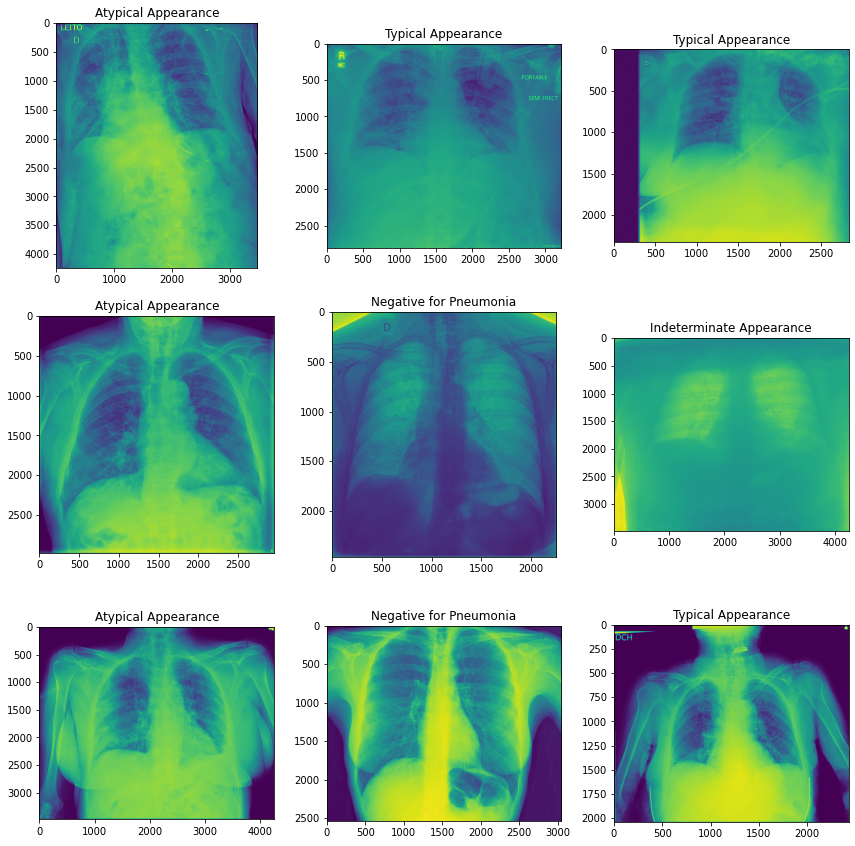

In [7]:
fig,_ = plt.subplots(figsize=(12,12))
for i in range(9):
    index = np.random.randint(0, len(data_info_df))
    observation = data_info_df.loc[index,:]
    img = pydicom.dcmread(observation.image_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img.pixel_array)
    plt.title(observation.class_name)
       
fig.tight_layout()    
plt.show()

* The original images have different sizes

### 3.2 Resizing image and bounding boxes

#### 3.2.1 Building Functions to Resize and Plot the Images

In [8]:
# a function for changing the 'boxes' to applicable format 

def extract_observation_info(item):
    """
    This function is used for extracting the useful information of the image 
    for resizing the image and bounding box
    
    item: one item(or one row) from the dataframe data_info_df
    
    return:
    image_info: a dictionary with elements, 
               1. image_path(string)
               2. label(numpy array with items [x,y,width,height,class_id])
    """
    try:
        bs = ast.literal_eval(item['boxes'])  
        if bs == []:
            b = np.array([0,0,1,1,0])
            image_info = {'image_path':item['image_path'], 'label':np.array([b]), 'category_id': [0]}
            return image_info
        bs = np.array([np.array([i['x'],i['y'],i['x']+i['width'],i['y']+i['height'], 1]) for i in bs])
        for b in bs:
            if (b[0] < 0) | (b[1]<0):   
                return False
        image_info = {'image_path':item['image_path'], 'label': bs, 'category_id': [1]*len(bs)}
        return image_info
    
    except ValueError:
        return False

In [9]:
# a function for resizing image and bounding box

def resize_image_box(image_dim,image_info, box_format='pascal_voc'):
    """
    This function is used to resize the image and bounding bounding box
    
    image_dim: tuple with integer, including the image size on x and y axis
    image_info: dictionary that includes the image id  
                image path,bounding box of original image
    return:
    Data of the resized iamge and the bounding boxes
    """
    img = pydicom.dcmread(image_info['image_path'])
    arr = img.pixel_array
    #arr = arr - np.min(arr)
    #arr = arr / np.max(arr)
    #arr = (arr * 255).astype(np.uint8)
    
    transform = A.Compose(
    [A.Resize(height=image_dim[1], width=image_dim[0], always_apply=True)],
    bbox_params=A.BboxParams(format=box_format))

    transformed = transform(image=arr, bboxes=image_info['label'],class_labels=image_info['category_id'])
    
    return transformed


# a function for resizing augmenting image with bounding box

def resize_augment_image_box(image_dim,image_info,box_format='pascal_voc',augment_type=A.HorizontalFlip(p=1)):
    """
    This function is used to resize and augment the image with bounding bounding box
    
    image_dim: tuple with integer, including the image size on x and y axis
    image_info: dictionary that includes the image id  
                image path,bounding box of original image
    augment_type: an function, a fuchtion that used to augment the image
    
    return:
    Data of the resized and augment iamge with the bounding boxes
    """
    
    img = pydicom.dcmread(image_info['image_path'])
    arr = img.pixel_array
    #arr = arr - np.min(arr)
    #arr = arr / np.max(arr)
    #arr = (arr * 255).astype(np.uint8)
    
    transform = A.Compose([
        #A.RandomCrop(width=image_dim[0], height=image_dim[1]),
        A.Resize(height=image_dim[1], width=image_dim[0], always_apply=True),
        augment_type
    ], bbox_params=A.BboxParams(format=box_format, min_area=512, min_visibility=0.1, label_fields=['class_labels']))

    transformed = transform(image=arr, bboxes=image_info['label'],class_labels=image_info['category_id'])
    
    return transformed


In [10]:
#Function for polting the resized image

image_dim = (256,256)

def plot_resized_image(num_rows,num_cols,df, augmentation=False, augment_type=A.HorizontalFlip(p=1)):
    
    """
    This function is use for plotting the resized images.
    
    num_rows: integer, the number of rows of the images
    num_cols: integer, the number of columns of the images
    df: data frame, with one column of the image paths for the observations
    augmentation: boolean, True if you want to plot the images after augmentation, otherwise False
    augment_type: an function, a fuchtion that used to augment the image
    
    return: None   
    """
    
    nrows = num_rows
    ncols = num_cols
    
    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    for i in range(len(df)):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        
        item = df.loc[i,:]
        im_info = extract_observation_info(item)
        if augmentation:
            resized_im = resize_augment_image_box(image_dim,im_info,augment_type=augment_type)
            
        else:    
            resized_im = resize_image_box(image_dim,im_info)
        plt.imshow(resized_im['image'])
        
        for i in resized_im['bboxes']:
            rect = patches.Rectangle((i[0], i[1]), 
                                      i[2]-i[0], i[3]-i[1], 
                                      linewidth=1, 
                                      edgecolor='r', 
                                      facecolor='none')
            # Add the patch to the Axes
            sp.add_patch(rect)
        plt.title(item.class_name)
    plt.show()

In [11]:
#Function for polting the original image

def plot_original_image(num_rows,num_cols,df):
    
    """
    This function is use for plotting the original images.
    
    num_rows: integer, the number of rows of the images
    num_cols: integer, the number of columns of the images
    df: data frame, with one column of the image paths for the observations
    
    return: None   
    """
    
    nrows = num_rows
    ncols = num_cols
    
    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    for i in range(len(df)):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        
        item = df.loc[i,:]
        img = pydicom.dcmread(item.image_path)
        plt.imshow(img.pixel_array)
        
        for i in ast.literal_eval(item['boxes']):
            rect = patches.Rectangle((i['x'], i['y']), 
                                      i['width'], i['height'], 
                                      linewidth=1, 
                                      edgecolor='r', 
                                      facecolor='none')
            # Add the patch to the Axes
            sp.add_patch(rect)
        plt.title(item.class_name)
    plt.show()

#### 3.2.2 Compare the Resized images with Bounding Boxes and the Original Image with Bounding Boxes

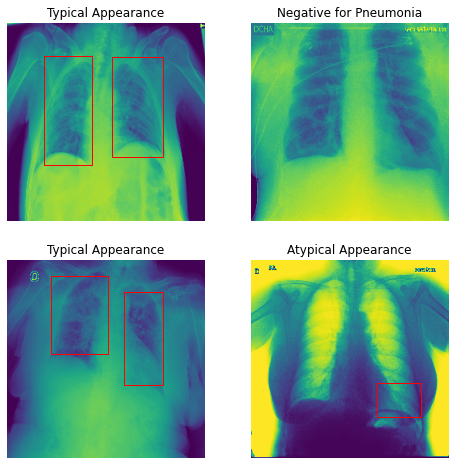

In [12]:
sample = data_info_df.loc[0:3,:].reset_index()
plot_resized_image(2,2,sample)

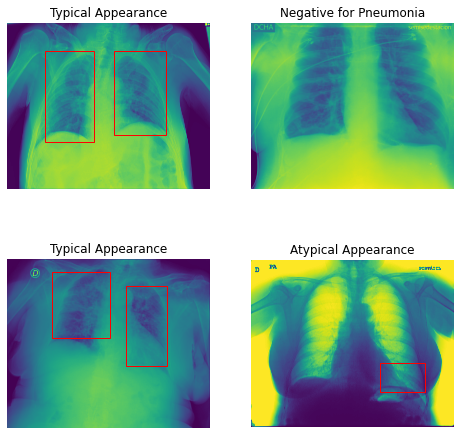

In [13]:
plot_original_image(2,2,sample)

* The resized images are the same shape(square), because I resized it to size 256*256. The original images are in different shapes and sizes.
* The location of the boxes are the same in the resized and original images.

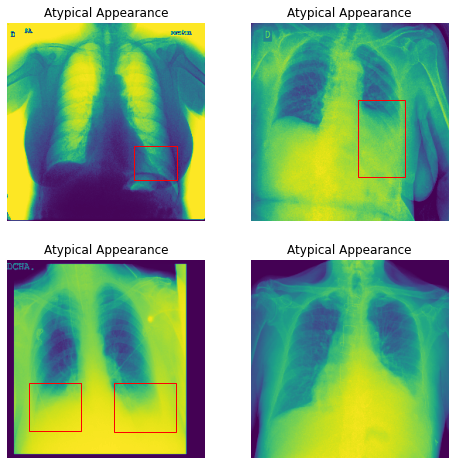

In [14]:
sample = data_info_df.loc[data_info_df['class_name']=='Atypical Appearance',:].reset_index().loc[0:3,:]
plot_resized_image(2,2,sample)

* This is the image in class 'Atypical Appearance' after resizing.

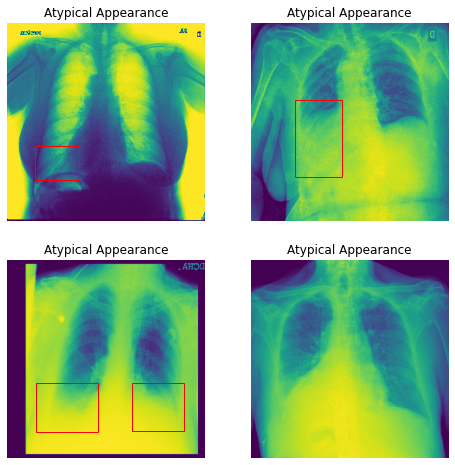

In [15]:
plot_resized_image(2,2,sample, augmentation=True)

* Horizontal Flip the images above

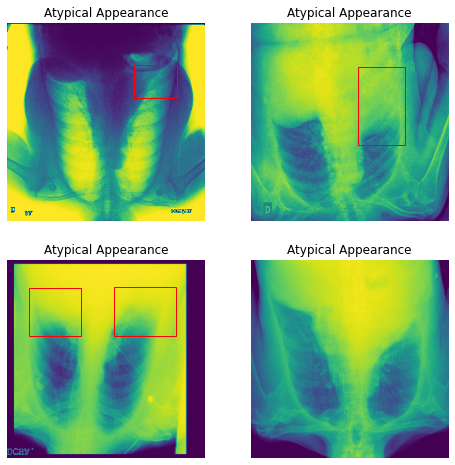

In [16]:
plot_resized_image(2,2,sample, augmentation=True, augment_type=A.VerticalFlip(p=1))

* Vertical Flip the images above

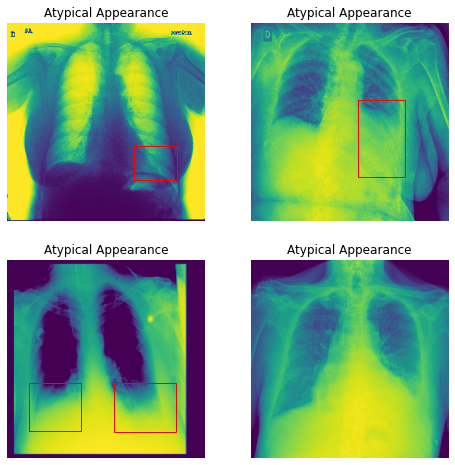

In [17]:
plot_resized_image(2,2,sample, augmentation=True, augment_type=A.RandomBrightnessContrast(p=1))

* Random Brightness Contrast

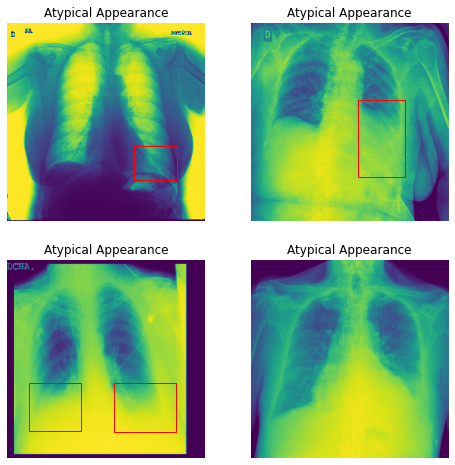

In [18]:
plot_resized_image(2,2,sample, augmentation=True, augment_type=A.MultiplicativeNoise(p=1))

* Multiplicative Noise

#### 3.2.3 Resize the Images of the Training Set and Save Them for Later Use

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Typical Appearance'),
  Text(1, 0, 'Negative for Pneumonia'),
  Text(2, 0, 'Atypical Appearance'),
  Text(3, 0, 'Indeterminate Appearance')])

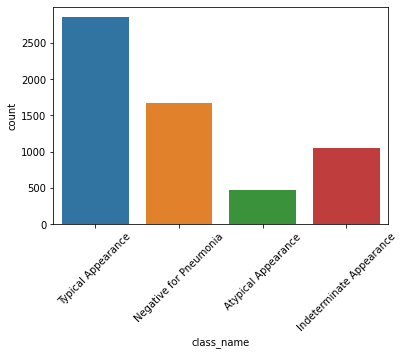

In [19]:
sns.countplot(data_info_df.class_name)
plt.xticks(rotation=45)

* Base on the class distribution above, I will try to apply image augmentation on class 'Atypical Apearance' and 'Indeterminate Appearance'. 

In [20]:
image_id = []
box = []
image_path = []
image_class = []
image_type = []
invail_item = []

save_dir = './train/'

os.makedirs(save_dir, exist_ok=True)

for i in range(len(data_info_df)):
    # set keep_ratio=True to have original aspect ratio
    item = data_info_df.loc[i,:]
    image_info = extract_observation_info(item)
    if image_info == False:
        invail_item.append(item['image_id'])
        continue
        
    resized_im = resize_image_box(image_dim,image_info, box_format='pascal_voc')
    image_id.append(item['image_id'])
    box.append(resized_im['bboxes'])
    image_class.append(item['class_name'])
    save_path = os.path.join(save_dir, item['image_id']+'1.png')
    image_path.append(save_path)
    image_type.append('original')
    im = Image.fromarray(resized_im['image'])
    im.save(save_path)

    #Apply MultiplicativeNoise and HorizontalFlip to class 'Atypical Appearance'
    if item['class_name']=='Atypical Appearance':
        
        aug_image1 = resize_augment_image_box(image_dim,image_info,augment_type=A.MultiplicativeNoise(p=1))
        image_id.append(item['image_id'])
        box.append(aug_image1['bboxes'])
        image_class.append(item['class_name'])
        save_path = os.path.join(save_dir, item['image_id']+'2.png')
        image_path.append(save_path)
        image_type.append('not original')
        im = Image.fromarray(aug_image1['image'])
        im.save(save_path)
        
        aug_image2 = resize_augment_image_box(image_dim,image_info)
        image_id.append(item['image_id'])
        box.append(aug_image2['bboxes'])
        image_class.append(item['class_name'])
        save_path = os.path.join(save_dir, item['image_id']+'3.png')
        image_path.append(save_path)
        image_type.append('not original')
        im = Image.fromarray(aug_image2['image'])
        im.save(save_path)
        
    #Apply MultiplicativeNoise and HorizontalFlip to class 'Indeterminate Appearance'
    if item['class_name']=='Indeterminate Appearance':
        aug_image = resize_augment_image_box(image_dim,image_info,augment_type=A.MultiplicativeNoise(p=1))
        image_id.append(item['image_id'])
        box.append(aug_image['bboxes'])
        image_class.append(item['class_name'])
        save_path = os.path.join(save_dir, item['image_id']+'2.png')
        image_path.append(save_path)
        image_type.append('not original')
        im = Image.fromarray(aug_image['image'])
        im.save(save_path)
        

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


In [21]:
# Create a data frame containing the information of the images

resized_info_df = pd.DataFrame({'image_id':image_id, 'box':box, 'image_path': image_path, 'image_class':image_class, 'image_type':image_type})
resized_info_df.head()
resized_info_df.to_csv('./resized_image_info.csv',index=False)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Typical Appearance'),
  Text(1, 0, 'Negative for Pneumonia'),
  Text(2, 0, 'Atypical Appearance'),
  Text(3, 0, 'Indeterminate Appearance')])

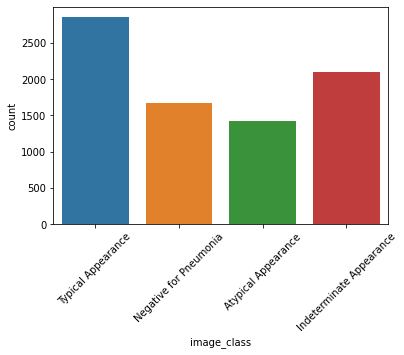

In [22]:
sns.countplot(resized_info_df.image_class)
plt.xticks(rotation=45)

* The plot above is the class distribution after image classification.

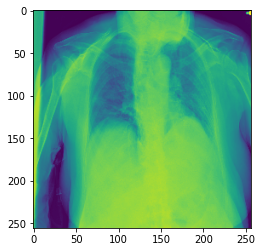

In [23]:
img = mpimg.imread(resized_info_df.image_path[30])
imgplot = plt.imshow(img)

### 3.4 Take a Look at the Image With Invalid Bounding Boxes

In [24]:
invail_item

['6ea732c63929_image']

In [25]:
data_info_df[data_info_df.image_id ==invail_item[0]]

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,num_boxes,class_name
2616,"[{'x': -3.55558, 'y': 1608.94276, 'width': 138...",opacity 1 -3.55558 1608.94276 1382.24912 3394....,05f85b86cdd6,../input/siim-covid19-detection/train/05f85b86...,05f85b86cdd6_study,6ea732c63929_image,0,1,0,0,2,Typical Appearance


* This obvervation have invalid boxes, the x-min of the box is less than 0, it should be greater than or equal to 0. Therefor, I will remove it from the data set. 